<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Read-in-the-1km-and-5km-water-vapor-images" data-toc-modified-id="Read-in-the-1km-and-5km-water-vapor-images-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Read in the 1km and 5km water vapor images</a></span></li></ul></div>

# Introduction

This notebook reads the files produced by level2_cartopy_resample and plots
them on a map.

It introduces a new functions to read the image and the area_def

# Setup

1. Run level2_cartopy_resample

1. Run the following test script
```
      python -m a301.install_tests.assign8_test
```
to check file locations.    


In [1]:
from matplotlib import cm

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from IPython.display import Image,display
from pyresample import geometry
import pdb

#Image('figures/MYBRGB.A2016224.2100.006.2016237025650.jpg',width=600)

In [2]:
%matplotlib inline
from matplotlib import cm
from a301.scripts.modismeta_read import parseMeta
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from IPython.display import Image,display
import a301
from pathlib import Path
from pyhdf.SD import SD, SDC
import pprint
import json

# Read in the 1km and 5km water vapor images

Use the two helper functions below to get the area_def and image

In [3]:
def area_def_from_dict(area_def_dict):
    """
    given an dictionary produced by dump_area_def
    return a pyresample area_def
    
    Parameters
    ----------
    
    area_def_dict: dict
        dictionary containing area_def parameters
        
    Returns
    -------
    
    pyresample area_def object

    """
    keys=['area_id','proj_id','name','proj_dict','x_size','y_size','area_extent']    
    arglist=[area_def_dict[key] for key in keys]
    area_def=geometry.AreaDefinition(*arglist)
    return area_def

def get_image(foldername,image_array_name):
    """
    write an image plus mmetadata to a folder under a301.map_dir
    
    Parameters
    ----------

    foldername:  Path object or string
        the path to the folder that holds the image files
        
    image_array_name:  str
        the root name for the npz and json files
        i.e. image.npz and image.json
        
    Returns: 
    
    image_array: ndarray with the image
    
    area_def:  pyresample area_def for image

    """
    image_file=Path(foldername) / Path(image_array_name + '.npz')
    image_array = np.load(image_file)[image_array_name]
    json_file = foldername / Path(image_array_name + '.json')
    with open(json_file,'r') as f:
        meta_dict=json.load(f)
    area_def = area_def_from_dict(meta_dict['area_def'])
    return image_array, area_def

In [4]:
import cartopy
def plot_image(resampled_image,area_def,vmin=0.,vmax=4.,palette='plasma'):
    """
    Make a cartopy plot of an image 
    
    Parameters
    ----------
    
    resampled_image: ndarray
       2-dimensional image that has be resampled onto an xy grid
       
    area_def:  pyresample area_def objet
       the area_def that was used by pyresample
       
    vmin,vmax:  floats
        upper and lower limits for the color map
        
    palette: str or matplotlib colormap
        colormap to use for plot
        
    Returns
    -------
    
    fig,ax: matmplotlib figure and axis objects
    """
    if isinstance(palette,str):
        pal = plt.get_cmap(palette)
    else:
        pal = palette
    pal.set_bad('0.75') #75% grey for out-of-map cells
    pal.set_over('r')  #color cells > vmax red
    pal.set_under('k')  #color cells < vmin black
    
    from matplotlib.colors import Normalize
    the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)
    crs = area_def.to_cartopy_crs()
    fig, ax = plt.subplots(1, 1, figsize=(10,10),
                              subplot_kw={'projection': crs})
    ax.gridlines(linewidth=2)
    ax.add_feature(cartopy.feature.GSHHSFeature(scale='coarse', levels=[1,2,3]));
    ax.set_extent(crs.bounds,crs)
    cs=ax.imshow(resampled_image, transform=crs, extent=crs.bounds, 
                 origin='upper',alpha=0.8,cmap=pal,norm=the_norm)
    fig.colorbar(cs,extend='both')
    return fig, ax

In [5]:
foldername=a301.map_dir / Path('wv_maps')
image_wv_ir, area_def_lr = get_image(foldername, 'wv_ir')

/Users/phil/mb36/lib/python3.6/site-packages/pyresample/_cartopy.py:36: UserWarning: 'cartopy' >= 0.17 required for better 'from_proj' functionality.
  warnings.warn("'cartopy' >= 0.17 required for better 'from_proj' "


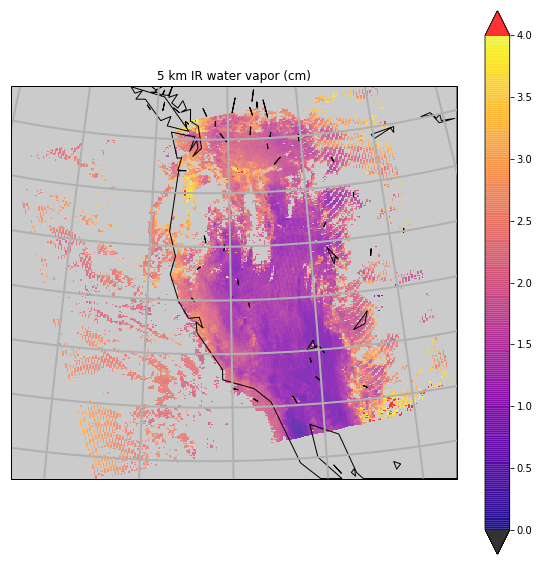

In [6]:
fig,ax=plot_image(image_wv_ir, area_def_lr)
ax.set_title('5 km IR water vapor (cm)');

(448, 297)


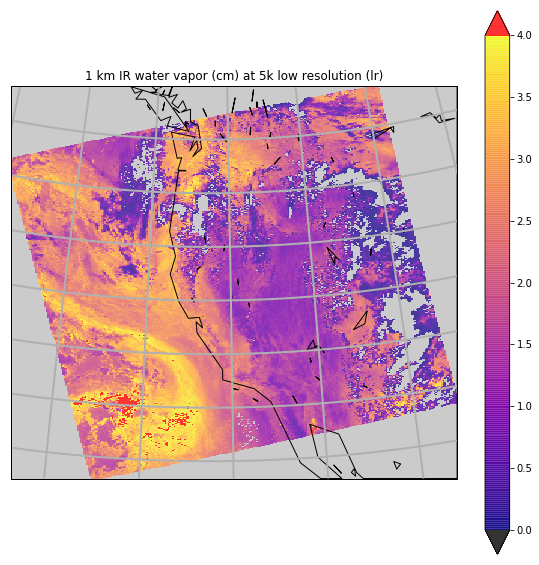

In [7]:
image_wv_nearir_lr, area_def_hr = get_image(foldername, 'wv_nearir_lr')
fig,ax=plot_image(image_wv_nearir_lr, area_def_hr)
ax.set_title('1 km IR water vapor (cm) at 5k low resolution (lr)');
print(image_wv_nearir_lr.shape)

(2244, 1489)


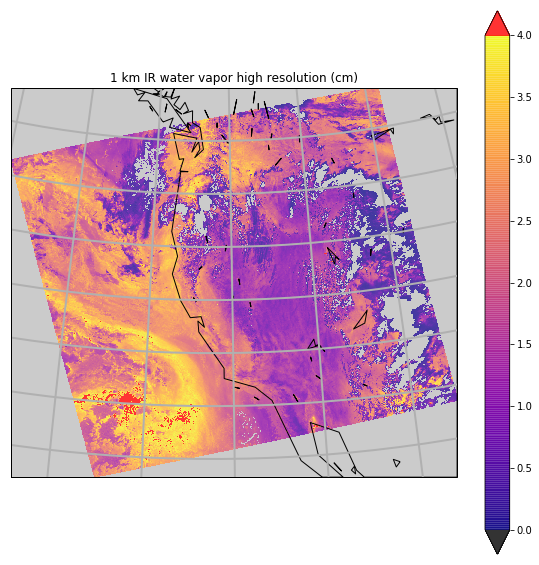

In [8]:
image_wv_nearir_hr, area_def_hr = get_image(foldername, 'wv_nearir_hr')
fig,ax=plot_image(image_wv_nearir_hr, area_def_hr)
ax.set_title('1 km IR water vapor high resolution (cm)');
print(image_wv_nearir_hr.shape)